In [4]:
import argparse
import torch
import torchvision
from torchvision.datasets import STL10, ImageFolder, CIFAR10, CIFAR100
from solo.data.pretrain_dataloader import dataset_with_index
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import transforms
from transformers import pipeline
import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os
from transformers import Owlv2Processor, Owlv2ForObjectDetection, Owlv2ImageProcessor
from PIL import ImageDraw
from IPython.display import Image 

MEANS_N_STD = {
    "cifar10": ((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    "cifar100": ((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
    "stl10": ((0.4914, 0.4823, 0.4466), (0.247, 0.243, 0.261)),
    "imagenet100": (IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    "imagenet": (IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
}


In [52]:
train_data_path = f"datasets/stl10"
dataset = "stl10"
download = True

mean, std = MEANS_N_STD[dataset]
augmentations = []
augmentations.append(transforms.ToTensor())
augmentations.append(transforms.ToPILImage())
augmentations.append(transforms.ToTensor())
augmentations = transforms.Compose(augmentations)
augmentations = augmentations if augmentations != [] else None

train_dataset = dataset_with_index(STL10)(
    train_data_path,
    split="train+unlabeled",
    download=download,
    transform=augmentations,
)

Files already downloaded and verified


In [53]:
# load csv file
df = pd.read_csv("stl10_preprocessed_info.csv")

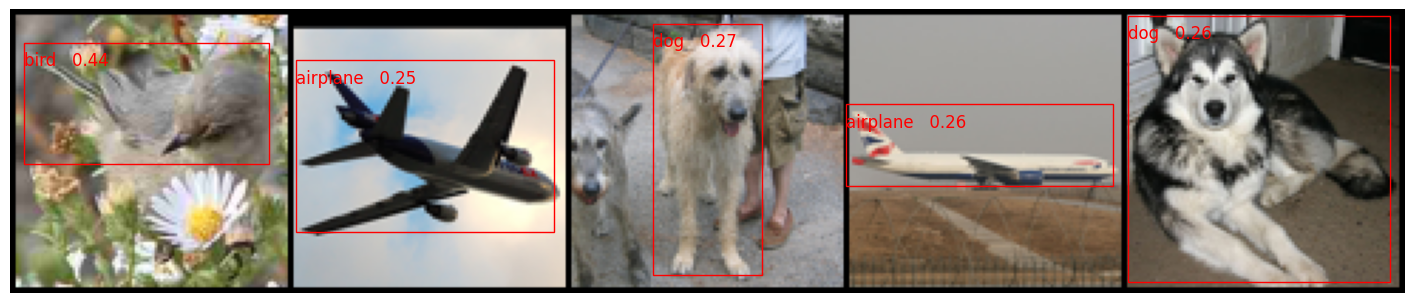

4.3125 11.34375 90.75 54.0


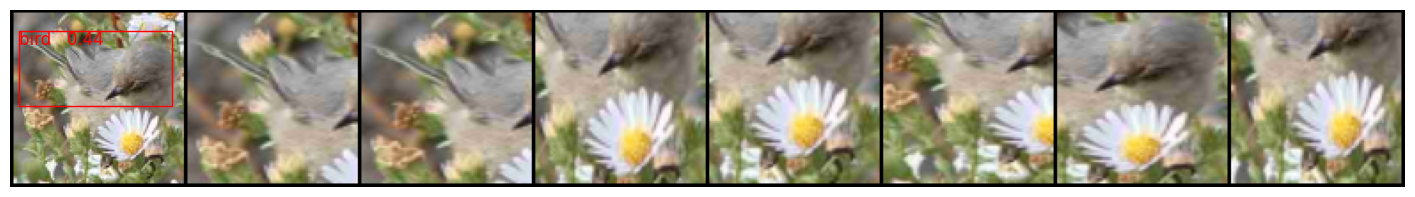

4.3125 11.34375 90.75 54.0


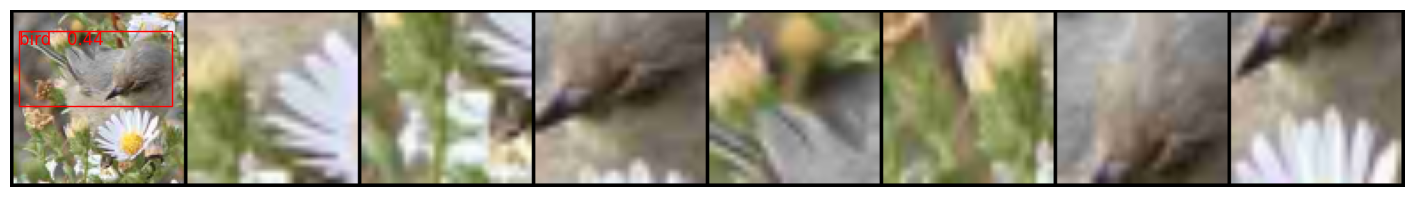

2.25 17.4375 93.375 78.0


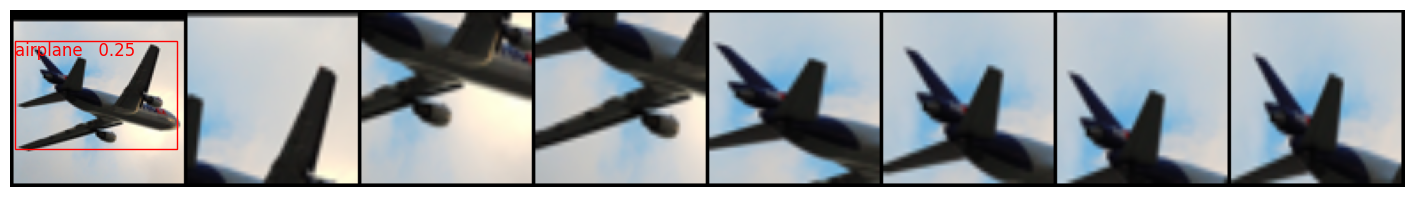

2.25 17.4375 93.375 78.0


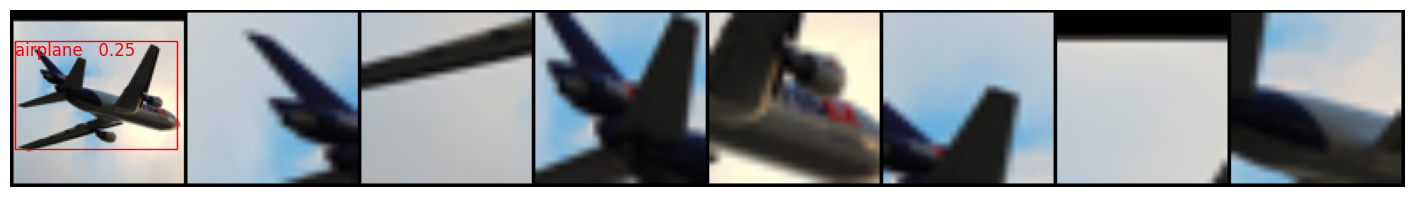

30.375 4.5 68.625 93.0


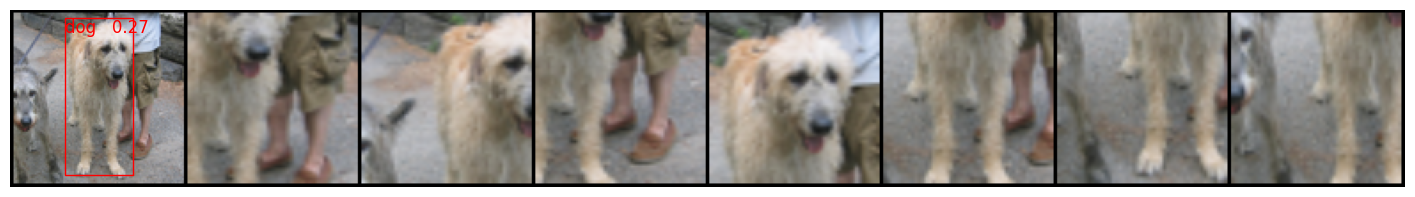

30.375 4.5 68.625 93.0


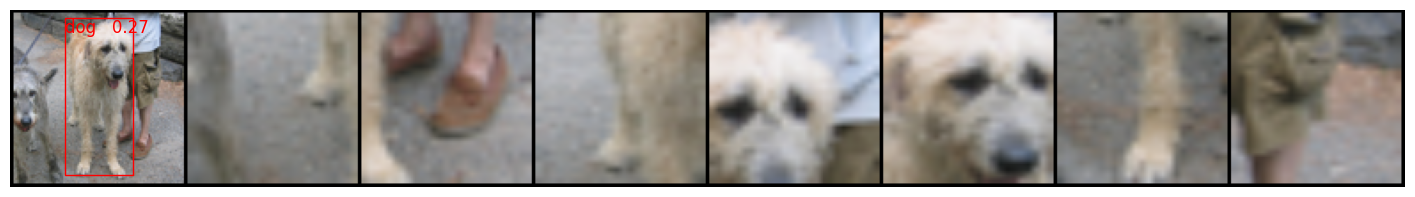

0.1875 33.0 94.5 61.875


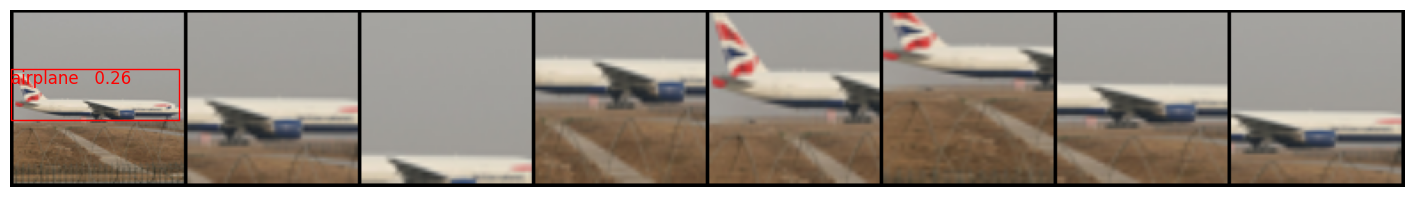

0.1875 33.0 94.5 61.875


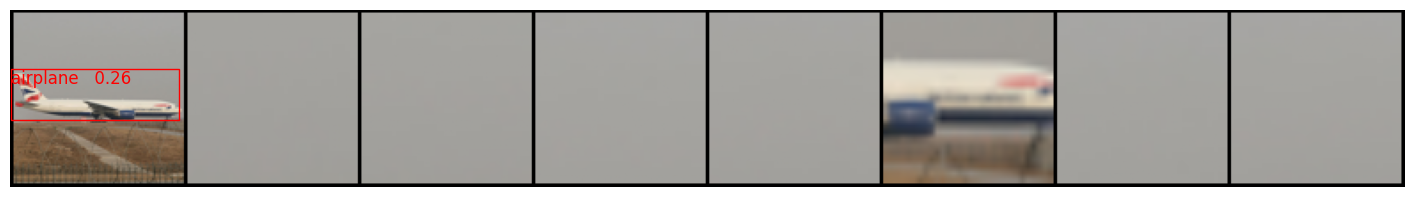

1.875 1.875 94.125 95.625


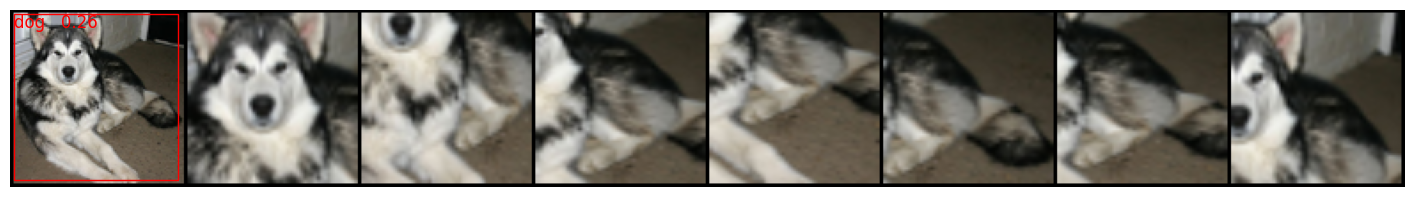

1.875 1.875 94.125 95.625


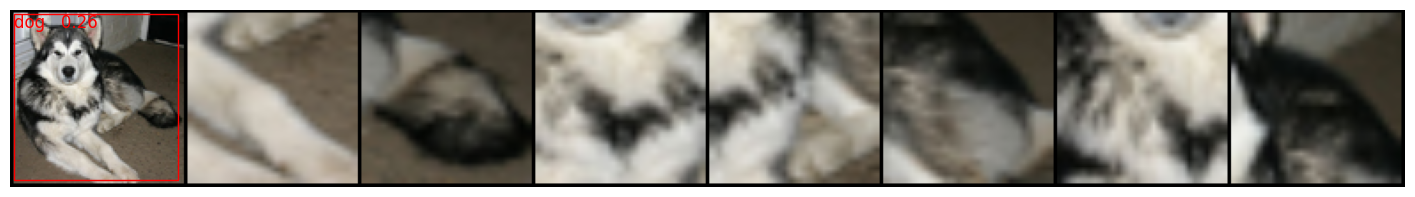

In [133]:
# plot image 50

indices = list(range(95, 100))
imgs  = [train_dataset[i][1] for i in indices]

grid = torchvision.utils.make_grid(imgs, scale_each=True, padding=2)


# draw bounding box from df for each index
fig, ax = plt.subplots()
ax.imshow(grid.permute(1, 2, 0))
for i, index in enumerate(indices):
    row = df.iloc[index]
    x1 = max(96*i, row["xmin"]*96 + 98*i)
    y1 = row["ymin"]*96
    x2 = max(96*i, row["xmax"]*96 + 98*i)
    y2 = row["ymax"]*96

    if row["predicted_label"] != 'none':
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1+8, row["predicted_label"] + f'   {row["rrc_area_lower_bound"]:.2f}', color='r', fontsize=12)

plt.axis('off')
fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.show()

# for each image, show several randomresized crops
for i, img in enumerate(imgs):
    row = df.iloc[indices[i]]
    min_crop_size = row["rrc_area_lower_bound"]
    
    cropper = transforms.RandomResizedCrop(96, scale=(min_crop_size, min_crop_size))
    cropped_imgs = [img] + [cropper(img) for _ in range(7)]
    grid = torchvision.utils.make_grid(cropped_imgs, scale_each=True, padding=2)

    fig, ax = plt.subplots()
    
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(18, 18)

    x1 = row["xmin"]*96
    y1 = row["ymin"]*96
    x2 = row["xmax"]*96
    y2 = row["ymax"]*96
    print(x1, y1, x2, y2)

    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1+8, row["predicted_label"] + f'   {row["rrc_area_lower_bound"]:.2f}', color='r', fontsize=12)

    plt.show()

    cropper = transforms.RandomResizedCrop(96, scale=(0.08, 0.08))
    cropped_imgs = [img] + [cropper(img) for _ in range(7)]
    grid = torchvision.utils.make_grid(cropped_imgs, scale_each=True, padding=2)

    fig, ax = plt.subplots()
    
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(18, 18)

    x1 = row["xmin"]*96
    y1 = row["ymin"]*96
    x2 = row["xmax"]*96
    y2 = row["ymax"]*96
    print(x1, y1, x2, y2)

    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1+8, row["predicted_label"] + f'   {row["rrc_area_lower_bound"]:.2f}', color='r', fontsize=12)

    plt.show()